# <center> <img src="../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> **Big Data** </center>
---
### <center> **Autumn 2025** </center>
---
### <center> **Examples on Structured Streaming (Kakfa producer)** </center>
---
**Profesor**: Pablo Camarillo Ramirez

**Estudiante**: Sergio Villa Rodríguez

# Create SparkSession

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming (Kafka)") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-12aa35aa-08ba-40ad-991a-c134e30c0834;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

# Create a data stream from a Kafka topic

In [2]:
# Create the remote connection
kafka_df = spark.readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "kafka:9093") \
            .option("subscribe", " videogame-telemetry-1") \
            .load()

kafka_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [3]:
from pyspark.sql.functions import year, month, day, from_json, col
from pyspark.sql.types import StructField, StringType
from pcamarillor.spark_utils import SparkUtils
vg_telemetry_df = kafka_df.select(kafka_df.value.cast("string").alias("value_str"))

# We need to extract the columns from the input JSON
location_schema = SparkUtils.generate_schema([("latitude", "float"), ("longitude", "float")])
schema_columns = [("player_id", "string"),
                  ("timestamp", "string"),
                  ("device", "string"),
                  ("action", "string"),
                  ("speed", "float"),
                  ("battery_level", "float")]
pkg_schema = SparkUtils.generate_schema(schema_columns)
pkg_schema = pkg_schema.add(StructField("location", location_schema))
vg_extracted_df = vg_telemetry_df.withColumn("telemetry", from_json(vg_telemetry_df.value_str, pkg_schema))

vg_extracted_df.printSchema()                                        

root
 |-- value_str: string (nullable = true)
 |-- telemetry: struct (nullable = true)
 |    |-- player_id: string (nullable = true)
 |    |-- timestamp: string (nullable = true)
 |    |-- device: string (nullable = true)
 |    |-- action: string (nullable = true)
 |    |-- speed: float (nullable = true)
 |    |-- battery_level: float (nullable = true)
 |    |-- location: struct (nullable = true)
 |    |    |-- latitude: float (nullable = true)
 |    |    |-- longitude: float (nullable = true)



In [4]:
# Extract the year, monht, and day from the timestamp column
vg_extracted_time_df = vg_extracted_df.withColumn("year", year(vg_extracted_df.telemetry.timestamp)) \
                                      .withColumn("month", month(vg_extracted_df.telemetry.timestamp)) \
                                      .withColumn("day", day(vg_extracted_df.telemetry.timestamp))

vg_extracted_time_df.printSchema()

root
 |-- value_str: string (nullable = true)
 |-- telemetry: struct (nullable = true)
 |    |-- player_id: string (nullable = true)
 |    |-- timestamp: string (nullable = true)
 |    |-- device: string (nullable = true)
 |    |-- action: string (nullable = true)
 |    |-- speed: float (nullable = true)
 |    |-- battery_level: float (nullable = true)
 |    |-- location: struct (nullable = true)
 |    |    |-- latitude: float (nullable = true)
 |    |    |-- longitude: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)



In [16]:
!mkdir /opt/spark/work-dir/data/vg_output

mkdir: cannot create directory ‘/opt/spark/work-dir/data/vg_output’: File exists


In [23]:
!ls

 artifacts
 Aura_gen_schema.ipynb
 Aura_Timestamps.ipynb
 axel_eg_gen_schema.ipynb
 axel_fernandez_schema.ipynb
 axelgallardo_gen_schema.ipynb
 bernardo_orozco_gen_shcema.ipynb
 carolinarellano_gen_schema.ipynb
 diego_orozco_lecture_08.ipynb
 JaimeGalindo_gen_schema.ipynb
 JoseAlfredo_gen_schema.ipynb
 lect08_reg_flo.ipynb
 lecture_05_oop.ipynb
 lecture_07_map_reduce.ipynb
 lecture08_sergio_villa.ipynb
 lecture_08_spark_sql_bernardo.ipynb
'lecture_08_spark_sql_Carlos _Chihenseck.ipynb'
 lecture_08_spark_sql_jaime_contreras.ipynb
 lecture_08_spark_sql-jose-juan-diaz-campos.ipynb
 lecture_09_data_sources.ipynb
 lecture_10_data_joins.ipynb
 lecture_11_storage_solutions.ipynb
 lecture_12_power_bi_airlines.ipynb
 lecture_12_storage_solutions_postgresql.ipynb
 lecture_13_storage_solutions_neo4j.ipynb
 lecture_14_intro_structured_streaming.ipynb
 lecture_14_intro_structured_streaming_juanalonso.ipynb
 lecture_15_structured_streaming_kafka.ipynb
 lecture_16_window-based_aggregations.ipynb
 lec

In [22]:
!pwd
!ls data/vg_output/

/opt/spark/work-dir/examples
ls: cannot access 'data/vg_output/': No such file or directory


In [24]:
# Finally, we send the stream to a files sink
query_files = vg_extracted_time_df.writeStream \
                .trigger(processingTime="10 seconds") \
                .partitionBy("year", "month", "day") \
                .format("parquet") \
                .option("header", "true") \
                .option("path", "/opt/spark/work-dir/data/vg_output/") \
                .option("checkpointLocation", "/opt/spark/work-dir/vg_checkpoint") \
                .start()

25/10/18 21:11:03 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
[Stage 1:>                                                          (0 + 1) / 1]

In [25]:
!ls /opt/spark/work-dir/data/vg_output/year=2025/month=10

'day=18'


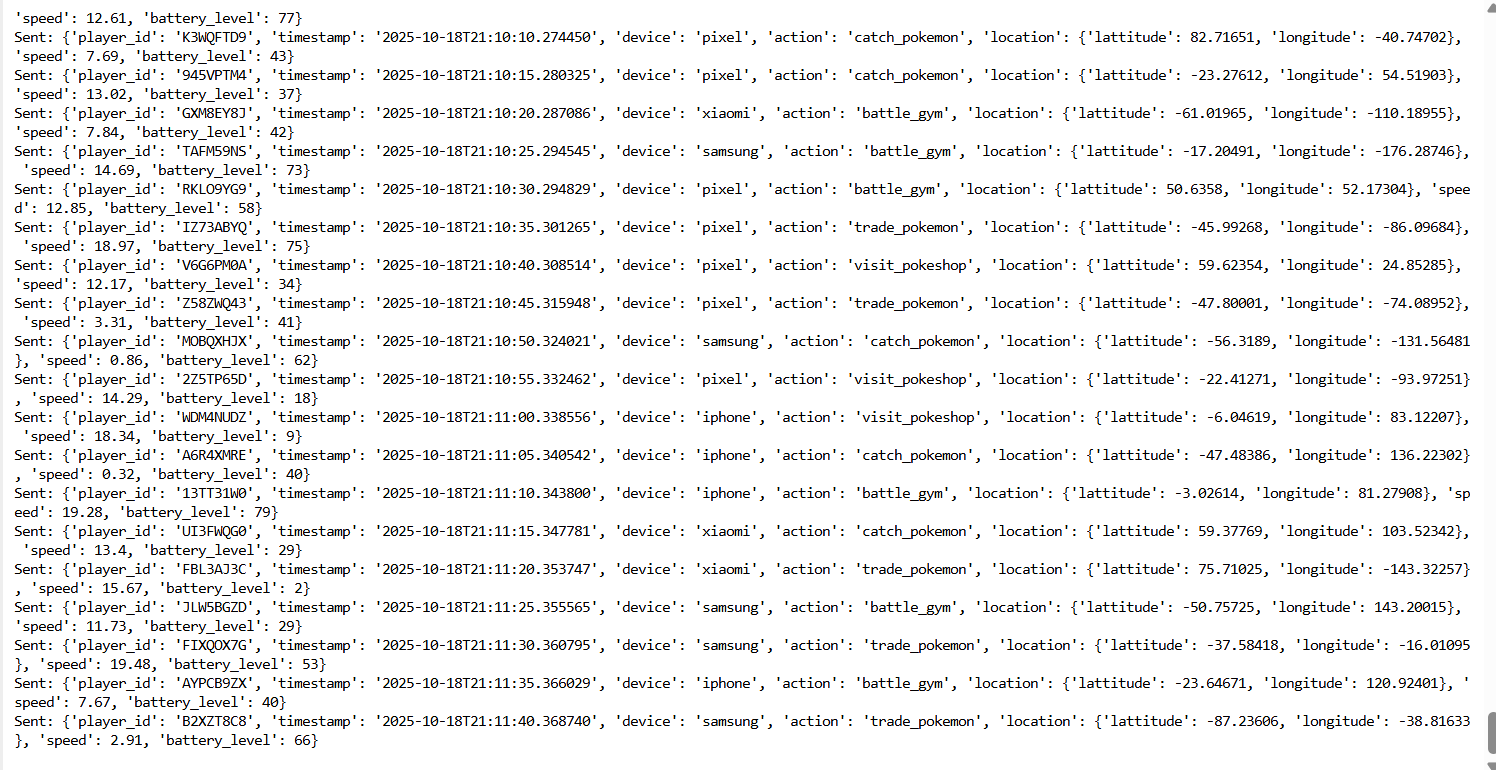
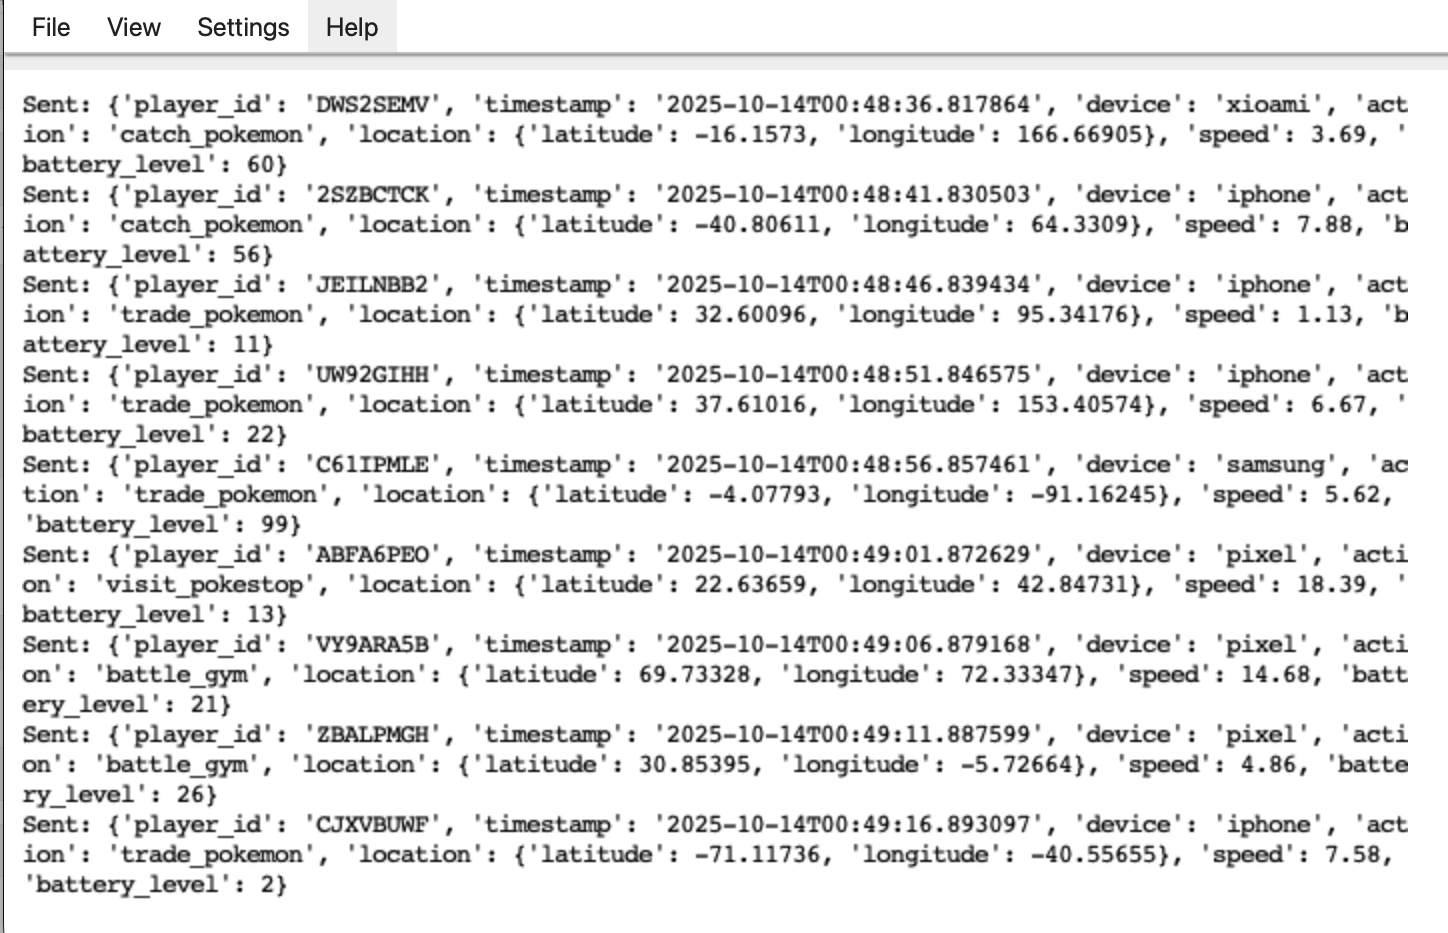

In [26]:
sc.stop()

25/10/18 21:12:01 ERROR MicroBatchExecution: Query [id = 4d3732a4-2111-44e0-885f-8c05aa385d37, runId = 30880ed4-71a3-43e9-9649-09ff0c4dec59] terminated with error
java.util.NoSuchElementException: None.get
	at scala.None$.get(Option.scala:627)
	at scala.None$.get(Option.scala:626)
	at org.apache.spark.sql.execution.datasources.BasicWriteJobStatsTracker$.metrics(BasicWriteStatsTracker.scala:240)
	at org.apache.spark.sql.execution.streaming.FileStreamSink.basicWriteJobStatsTracker(FileStreamSink.scala:148)
	at org.apache.spark.sql.execution.streaming.FileStreamSink.addBatch(FileStreamSink.scala:185)
	at org.apache.spark.sql.execution.streaming.MicroBatchExecution.$anonfun$runBatch$17(MicroBatchExecution.scala:879)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:162)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:268)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$